# Seminar Software Composition - Assessing Source Code Comments Quality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import nltk
import seaborn as sb


sb.set()
nltk.download('punkt')
plt.rcParams['figure.dpi'] = 100 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ludo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# helper function to print markdown
from IPython.display import display, Markdown, Latex
def print_md(string):
    display(Markdown(string))

## Dataset preparation

## Comment length

### Preprocessing

In [3]:
from scipy import stats

def prepare_dataset(df, process_columns):
    print(f"Dataset length before preprocessing : {len(df)}")
    
    # extract the columns which don't need to be processed
    filt_df = df.copy()
    for column in process_columns:
        filt_df = filt_df.loc[:, df.columns != column]
        
        
    for column in process_columns:
        s = df[column]
        
        # remove the NaN values
        s.fillna(" ", inplace=True)
        
        # remove the outliers
        z_scores = stats.zscore(s.map(lambda c: len(c)))
                    
        # filter the values that have more than 3 times the std (3 zscores)
        
        # in our case, do not absolute the values since we only care about too long comments
        # z_scores = np.abs(z_scores)
        
        filtered_entries = (z_scores < 3)
    
        s = s[filtered_entries]
        
        
        #filt_df = filt_df.assign(column=s.values)
        #filt_df.reset_index(drop=True, inplace=True)
        #s.reset_index(drop=True, inplace=True)
        
        filt_df = pd.concat([filt_df, s], axis=1)     
        filt_df.dropna(inplace=True)
            
    print(f"Dataset length after preprocessing : {len(filt_df)}")
    
    #filt_df.columns = df.columns
    return filt_df

In [4]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ludo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess_comment(comment, stopwords):
    # split the comment text into lowercase words
    comment = nltk.word_tokenize(comment)        
    comment = [word.lower() for word in comment if word.isalnum()]
    

    # filter the stopwords and the punctuation
    try:
        comment = [word for word in comment if word not in stopwords]
    except:
        print(e)
    
    return comment

### Computations

In [6]:
from statistics import mean, median

def print_comment_length_metrics(comments):
    MIN_COMMENT_LENGTH = 3

    n_empty_comments = sum(map(lambda comment: 1 if len(comment) == 0 else 0, comments))
    n_lower_length = sum(map(lambda comment: 1 if len(comment) < MIN_COMMENT_LENGTH and len(comment) > 0 else 0, comments))

    print_md(f"Total number of comments : **{len(comments)}**\n")
    print_md(f"Number of empty comments : **{n_empty_comments}** **({(n_empty_comments / len(comments))*100:.1f} %)**")
    print_md(f"Number of comments with less than **{MIN_COMMENT_LENGTH}** words (and **not empty**) : **{n_lower_length}**  (**{(n_lower_length / len(comments))*100:.1f} %**)")
    
    
    map_len = map(lambda c: len(c), comments)
    non_empty = list(filter(lambda c_len: c_len > 0, map_len))
    
    print_md(f"Average comment length (excluding empty ones) : **{mean(non_empty):.0f}** words, median : **{median(non_empty):.0f}**")

### Plots

In [7]:
import matplotlib.pyplot as plt
from statistics import mean, median
from matplotlib.ticker import PercentFormatter
import numpy as np

def plot_histogram(values, bins, title, xlabel, ylabel, yscale_val='linear', title_additional_info="",
                   plot_average=False, plot_median=False, plot_percentages = False, cumulative=1):
      
    if title_additional_info != "":
        title = f"{title} ({title_additional_info})"
    
    if cumulative == 1:
        #title = f"{title} (cumulative)"
        plt.hist(values, bins=bins, weights=np.ones(len(values)) / len(values), alpha=0.6, cumulative=1, label='cumulative')
    
    if(plot_percentages):
        plt.hist(values, bins=bins, weights=np.ones(len(values)) / len(values), cumulative=0, label='single')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.title(f"\nTotal : {len(values)}", fontsize=12)
    else:
        plt.hist(values, bins=bins, cumulative=cumulative)
        plt.yscale(value=yscale_val)
    
    
    plt.suptitle(title, fontsize=16, y=.995)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    
    plt.grid(False)
    plt.gca().yaxis.grid(True)
    
    if(plot_average):
        mean_val = mean(values)
        plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=1)
        plt.min_ylim, max_ylim = plt.ylim()
        plt.text(mean_val*1.1, max_ylim*0.7, f"Avg : {mean_val:.2f}")
    if(plot_median):
        median_val = median(values)
        plt.axvline(median_val, color='k', linestyle='dashed', linewidth=1)
        plt.min_ylim, max_ylim = plt.ylim()
        plt.text(median_val*1.5, max_ylim*0.6, f"Median : {median_val:.2f}", fontsize=14)
    
    plt.legend(loc='upper right')
    plt.show()


In [8]:
def plot_hist_comments_len(comments, title_additional_info = ""):
    comments_len = map(lambda c: len(c), comments)
    comments_len = filter(lambda c: c > 0, comments_len)
    comments_len = list(comments_len)
            
    plot_histogram(comments_len, bins=20, yscale_val='log', 
                    title="Comments length", title_additional_info=title_additional_info,
                    ylabel='Ratio of comments', xlabel='Number of words in the comment', 
                    plot_average=False, plot_median=True, plot_percentages=True, cumulative=1)


## Analyzing language properties of comments

In [9]:
from readcalc import readcalc
from IPython.utils import io

def get_gunning_fog(comment):
    with io.capture_output() as captured:
        calc = readcalc.ReadCalc(comment)
        val = calc.get_gunning_fog_index()
    return val 

def get_flesch_reading(comment):
    with io.capture_output() as captured:
        calc = readcalc.ReadCalc(comment)
        val = calc.get_flesch_reading_ease()
    return val 

def get_smog_index(comment):
    with io.capture_output() as captured:
        calc = readcalc.ReadCalc(comment)
        val = calc.get_smog_index()
    return val 


indices_functions = {
    'flesch_reading_ease':get_flesch_reading,
    'gunning_fog':get_gunning_fog,
    'smog_index':get_smog_index,
}

def compute_reading_ease_metrics(comments):
    # init the dictionnary that will contain each index metric as key and the values for each comment as the values
    indices_values = {}
    for index_label in indices_functions.keys():
        indices_values[index_label] = []

    for comment in tqdm(comments):
        for index_label, index_func in indices_functions.items():
            val = index_func(comment)
            indices_values[index_label].append(val)
            
    return indices_values

In [10]:
def plot_indices_values(indices_values, title_additional_info=""):
    for label, values in indices_values.items():
        values = list(filter(lambda val: val > 0, values))
        plot_histogram(values, bins=20, 
                        title=f"Readability of comments using {label}", title_additional_info=title_additional_info, 
                        yscale_val='linear', 
                        ylabel='Ratio of comments',
                        xlabel='Readability score',
                        plot_median=True, plot_percentages=True)

### Indices explained

#### Flesch reading ease

Higher is better.

[Source](https://yoast.com/flesch-reading-ease-score)
- 90-100	very easy to read, easily understood by an average 11-year-old student-
- 80-90	easy to read
- 70-80	fairly easy to read
- 60-70	easily understood by 13- to 15-year-old students
- 50-60	fairly difficult to read
- 30-50	difficult to read, best understood by college graduates
- 0-30	very difficult to read, best understood by university graduates

#### Gunning Fog

Lower is better.

[Source](https://en.wikipedia.org/wiki/Gunning_fog_index)
- 17	College graduate
- 16	College senior
- 15	College junior
- 14	College sophomore
- 13	College freshman
- 12	High school senior
- 11	High school junior
- 10	High school sophomore
- 9	High school freshman
- 8	Eighth grade
- 7	Seventh grade
- 6	Sixth grade

#### Smog index

[https://en.wikipedia.org/wiki/SMOG]
$grade = 1.043 \sqrt{number \; of \; polysyllables* \frac{30}{number\; of \;sentences}} + 3.1291$

Results can be interpreted using this [table](https://www.textcompare.org/readability/smog-index#Grade-Conversion)

#### Split the class into subwords

In [11]:
import re

def camel_case_splitter(word):
    splitted = re.sub('([A-Z][a-z]+)', r' \1', re.sub('(([A-Z]|[0-9A-Z])+)', r' \1', word)).split()
    return splitted

### Code-Comment coherence

#### C_Coeff explanation

The comparison counts how many words from one set
correspond to a similar word in the other set. Two words are
similar iff their Levenshtein distance is **smaller than 2**. 

The $c_{coeff}$ metric denotes the number of corresponding words
divided by the total number of comment words. 

Based on preliminary experiments with manual evaluation,
we set two thresholds and inspect member comments with
**$c_{coeff} = 0$ and $c_{coeff} > 0.5$**.

*Quality Analysis of Source Code Comments*

In [12]:
from nltk.metrics import edit_distance

# if the edit distance is smaller than this threshold, words are considered similar
DIST_SIMILARITY_THRESHOLD = 2

stopwords = nltk.corpus.stopwords.words('english')

def compute_c_coeff(comments, class_names, class_names_splitter=camel_case_splitter, stopwords=[]): 
    class_coeff_dict= {}

    for comment, class_name in tqdm(zip(comments, class_names)):
        # split class name into tokens by camel case and set them to lower case
        splitted_class_name = class_names_splitter(class_name)
        splitted_class_name = [word.lower() for word in splitted_class_name]

        # tokenize, remove stop words and split commment into words
        comment = preprocess_comment(comment, stopwords=stopwords)

        # if this is an empty comment, skip this comment computation and discard it
        if len(comment) == 0:
            class_coeff_dict[class_name] = -1
            continue

        n_similar = 0
        for comment_word in comment:
            for class_word in splitted_class_name:
                if edit_distance(comment_word, class_word) < DIST_SIMILARITY_THRESHOLD:
                    n_similar += 1
                    break

        c_coeff = n_similar / (float)(len(comment))
        class_coeff_dict[class_name] = c_coeff
    
    return class_coeff_dict

### Sample some examples

In [13]:
def plot_c_coeffs(class_coeff_dict, title_additional_info=""):
    values = list(filter(lambda val: val >= 0, class_coeff_dict.values()))
    plot_histogram(values, bins=10, 
                        title=f"C_Coeff of class comments", title_additional_info=title_additional_info,
                        yscale_val='log', 
                        ylabel='Ratio of comments',
                        xlabel='C_Coeff',
                        plot_median=True,
                        plot_percentages=True)

In [14]:
from functools import reduce

THRESH_USELESS_HIGH = 0.75
THRESH_USELESS_LOW = 0.5

def print_c_coeffs_metrics(class_coeff_dict, thresh_high, thresh_low):
    c_coeff_vals = class_coeff_dict.values()
    
    n_non_empty = reduce(lambda n, val: n + 1 if val >= 0 else n, c_coeff_vals, 0)
    
    
    n_zero = reduce(lambda n, val: n + 1 if val == 0 else n, c_coeff_vals, 0)
    n_low = reduce(lambda n, val: n + 1 if val >= thresh_low else n, c_coeff_vals, 0)
    n_high = reduce(lambda n, val: n + 1 if val >= thresh_high else n, c_coeff_vals, 0)

    # TODO : check some examples that have too similar 
    # EG comment number of words
    
    print_md(f"Number of **non-empty** comments : **{n_non_empty}**\n")
    print_md(f"Number of comments with **c_coeff = 0** (completely dissimilar) : **{n_zero} ({n_zero*100/n_non_empty:.2f}) %**")
    print_md(f"Number of comments with **c_coeff >= {thresh_low}** (quite similar) : **{n_low} ({n_low*100/n_non_empty:.2f}) %**")
    print_md(f"Number of comments with **c_coeff >= {thresh_high}** (really similar) : **{n_high} ({n_high*100/n_non_empty:.2f}) %**")

#### Print some comments with values in between the thresholds

In [15]:
import random
N_PRINT = 5

"""
Sample n_print comments from the dictionary given in parameter and print the comment, class name and value from the dataset
"""
def sample_print_c_coeff(class_coeff_dict, df, n_print, comment_label='comment', class_label='class'):
    thresh_high_classes = {k:v for k, v in class_coeff_dict.items() if v >= THRESH_USELESS_HIGH}
    thresh_low_classes = {k:v for k, v in class_coeff_dict.items() if v >= THRESH_USELESS_LOW and v < THRESH_USELESS_HIGH}


    print_md(f"Comments with **c_coeff >= {THRESH_USELESS_LOW} and < {THRESH_USELESS_HIGH}**")
    print("---------------------------------------------------------------------")
    __sample_print_comments__(thresh_low_classes, df, n_print, comment_label, class_label)
    print_md(f"\nComments with **c_coeff >= {THRESH_USELESS_HIGH}**")
    print("---------------------------------------------------------------------")
    __sample_print_comments__(thresh_high_classes, df, n_print, comment_label, class_label)

def __sample_print_comments__(class_coeff_dict, df, n_print, comment_label='comment', class_label='class'):
    if(len(class_coeff_dict.keys()) < n_print):
        n_print = len(class_coeff_dict.keys())
    for i in range(0, n_print):
        class_name, val = random.choice(list(class_coeff_dict.items()))

        row = df.loc[df[class_label] == class_name]
        comment = row[comment_label].values[0]
        print_md(f"**Class** : *{class_name}*, **c_coeff = {val:.2f}**")
        print_md(f"*{comment}*")

### Pipeline

## Pharo comments

In [16]:
DATASET_FILE = 'data/pharo/class_comments_pharo.csv'

dataset = pd.read_csv(DATASET_FILE, header=None, names=['class', 'comment'])

dataset.head(5)

,class,comment
0,AColorSelectorMorph,ColorComponentSelector showing an alpha gradie...
1,ASTCache,I am a simple cache for AST nodes correspondin...
2,ASTCacheReset,Announcement signaled to tell that the default...
3,ASTCacheResetTest,NaN
4,ASTEvaluationTest,I am testing AST evaluation


In [17]:
df = dataset.copy()
df = prepare_dataset(df, ['comment'])

Dataset length before preprocessing : 7863
Dataset length after preprocessing : 7758


In [18]:
comments = df["comment"]
comments = [preprocess_comment(comment, stopwords=stopwords) for comment in comments]

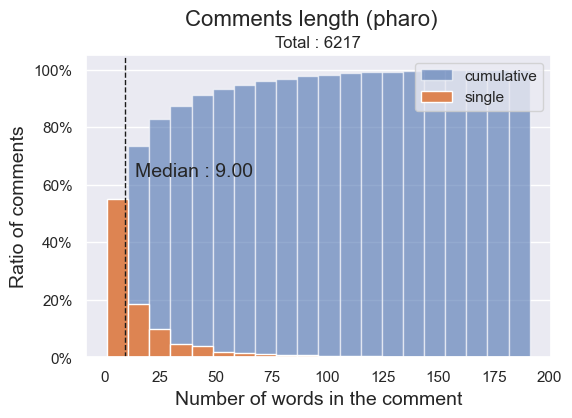

Total number of comments : **7758**


Number of empty comments : **1541** **(19.9 %)**

Number of comments with less than **3** words (and **not empty**) : **196**  (**2.5 %**)

Average comment length (excluding empty ones) : **18** words, median : **9**

In [19]:
plot_hist_comments_len(comments, title_additional_info="pharo")
print_comment_length_metrics(comments)

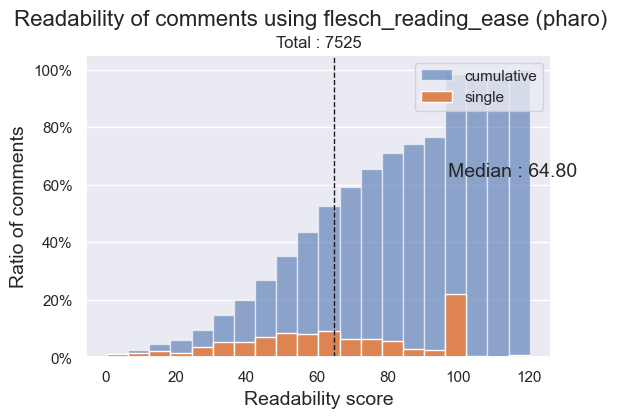

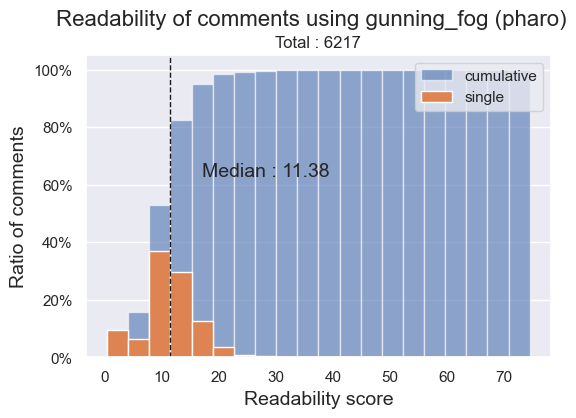

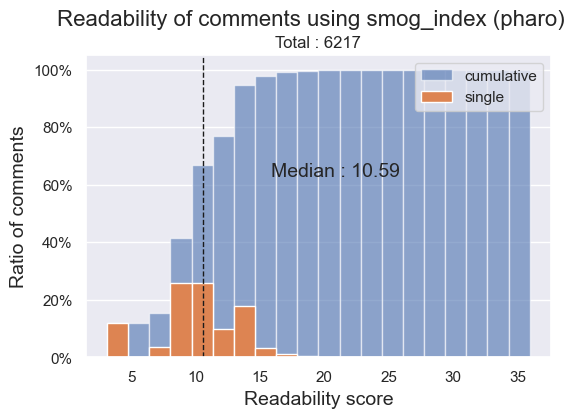

In [20]:
indices_values = compute_reading_ease_metrics(df["comment"])
plot_indices_values(indices_values, "pharo")

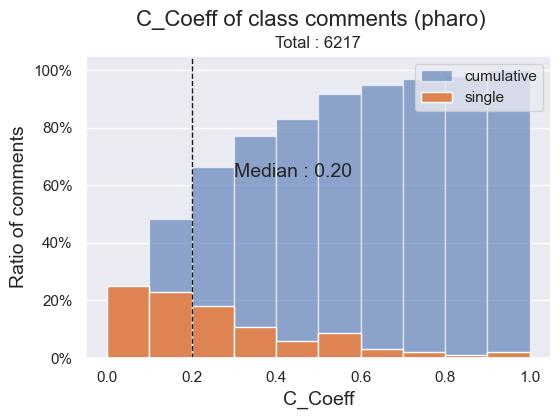

Number of **non-empty** comments : **6217**


Number of comments with **c_coeff = 0** (completely dissimilar) : **662 (10.65) %**

Number of comments with **c_coeff >= 0.5** (quite similar) : **1051 (16.91) %**

Number of comments with **c_coeff >= 0.75** (really similar) : **312 (5.02) %**

Comments with **c_coeff >= 0.5 and < 0.75**

---------------------------------------------------------------------


**Class** : *SpecInterpreter*, **c_coeff = 0.50**

*A SpecInterpreter is a interpreter for spec presenters*

**Class** : *MorphTreeColumn*, **c_coeff = 0.50**

*A column in a morphic based tree*

**Class** : *OSNullWindowHandle*, **c_coeff = 0.50**

*i am a handle for null window , created using OSNullWindowDriver.*

**Class** : *GLMReplacePresentationsStrategy*, **c_coeff = 0.50**

*This strategy replaces the presentations from the pane of the destination port.*

**Class** : *OCCopyingTempVariable*, **c_coeff = 0.54**

*A copying temp is a temp that is copied into a block that later reads this variable.Not: the temp vector is passed as a copying temp, too.*


Comments with **c_coeff >= 0.75**

---------------------------------------------------------------------


**Class** : *ZLibReadStream*, **c_coeff = 1.00**

*A ZLib read stream*

**Class** : *InstanceVariableEyeElement*, **c_coeff = 1.00**

*I am an eye element for instance variables.*

**Class** : *SUnitExtensionsTest*, **c_coeff = 1.00**

*SUnit tests for extensions to SUnit*

**Class** : *InstanceVariableEyeElement*, **c_coeff = 1.00**

*I am an eye element for instance variables.*

**Class** : *ClyMethodContextOfFullBrowser*, **c_coeff = 0.80**

*I am a context of selected methods in full browser*

In [21]:
class_coeff_dict = compute_c_coeff(df["comment"], df["class"], class_names_splitter=camel_case_splitter, stopwords=stopwords)
plot_c_coeffs(class_coeff_dict, 'pharo')

print_c_coeffs_metrics(class_coeff_dict, thresh_high=THRESH_USELESS_HIGH, thresh_low=THRESH_USELESS_LOW)

sample_print_c_coeff(class_coeff_dict=class_coeff_dict, df=df, n_print=N_PRINT)

## Python comments

In [22]:
import os
DATA_PATH = 'data/python/'

In [23]:
MERGE_DATASETS = True
python_datasets_dict = {}


for filename in os.listdir(DATA_PATH):
    df = pd.read_csv(f"{DATA_PATH}{filename}")
    # find the dot at the end and slice to remove the extension to create the label (EG pipenv, django, etc.)
    dataset_label = filename[:filename.rfind('.')]
    python_datasets_dict[dataset_label] = df
    
if MERGE_DATASETS:
    df = pd.concat([prepare_dataset(ds, ['classComment']) for ds in python_datasets_dict.values()])
    python_datasets_dict = {'python':df}

Dataset length before preprocessing : 8750
Dataset length after preprocessing : 1015
Dataset length before preprocessing : 543
Dataset length after preprocessing : 201
Dataset length before preprocessing : 521
Dataset length after preprocessing : 272
Dataset length before preprocessing : 1753
Dataset length after preprocessing : 341
Dataset length before preprocessing : 1866
Dataset length after preprocessing : 1128
Dataset length before preprocessing : 2699
Dataset length after preprocessing : 468
Dataset length before preprocessing : 79
Dataset length after preprocessing : 40


In [28]:
def pipeline(df, class_label, comment_label, experiment_label = ""):
    df = df.copy()
    if experiment_label != 'python':
        df = prepare_dataset(df, [comment_label])
    
    
    # comments length metrics
    comments = df[comment_label]
    comments = [preprocess_comment(comment, stopwords=stopwords) for comment in comments]
    
    plot_hist_comments_len(comments, title_additional_info=experiment_label)
    print_comment_length_metrics(comments)
    
    # reading indices values
    indices_values = compute_reading_ease_metrics(df[comment_label])
    plot_indices_values(indices_values, experiment_label)
    
    # class_coeff_metrics
    class_coeff_dict = compute_c_coeff(df[comment_label], df[class_label], class_names_splitter=camel_case_splitter, stopwords=stopwords)
    plot_c_coeffs(class_coeff_dict, experiment_label)
    print_c_coeffs_metrics(class_coeff_dict, thresh_high=THRESH_USELESS_HIGH, thresh_low=THRESH_USELESS_LOW)
    sample_print_c_coeff(class_coeff_dict=class_coeff_dict, df=df, n_print=N_PRINT, comment_label=comment_label, class_label=class_label)

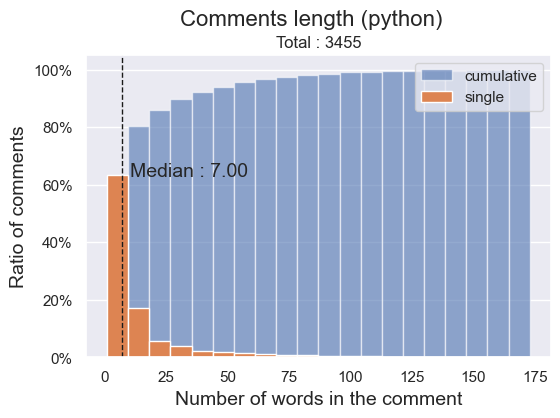

Total number of comments : **3465**


Number of empty comments : **10** **(0.3 %)**

Number of comments with less than **3** words (and **not empty**) : **206**  (**5.9 %**)

Average comment length (excluding empty ones) : **14** words, median : **7**

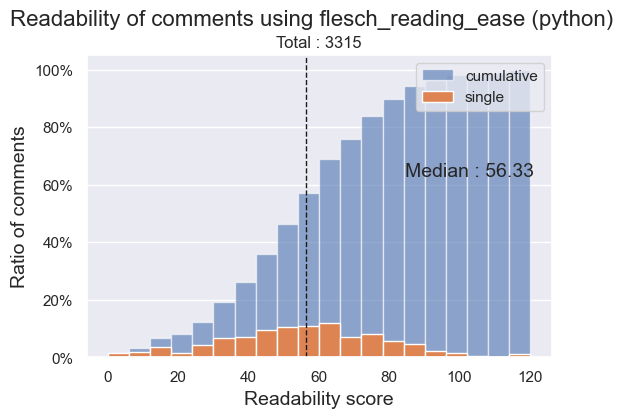

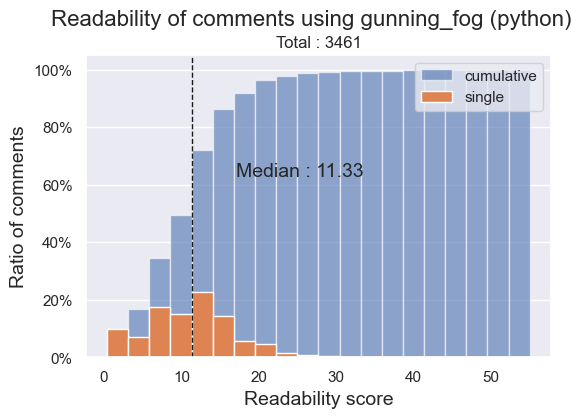

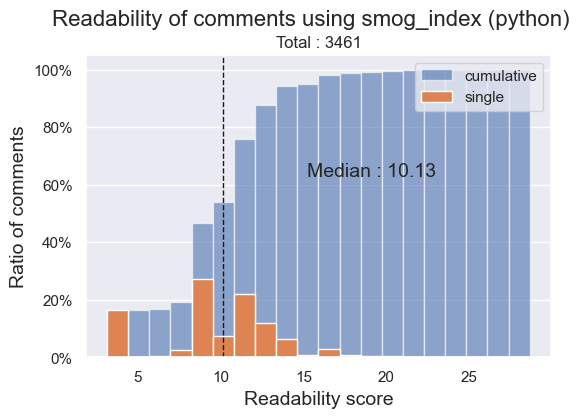

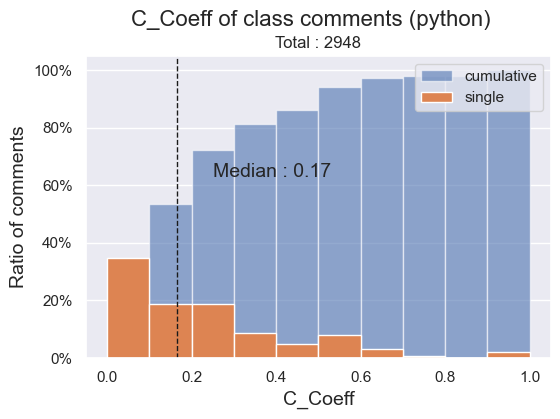

Number of **non-empty** comments : **2948**


Number of comments with **c_coeff = 0** (completely dissimilar) : **639 (21.68) %**

Number of comments with **c_coeff >= 0.5** (quite similar) : **406 (13.77) %**

Number of comments with **c_coeff >= 0.75** (really similar) : **83 (2.82) %**

Comments with **c_coeff >= 0.5 and < 0.75**

---------------------------------------------------------------------


**Class** : *ArchiveIndexView*, **c_coeff = 0.50**

*
Top-level archive of date-based items.
*

**Class** : *GPGCheckKeys*, **c_coeff = 0.50**

*
Sanity check your keys and profiles
*

**Class** : *MetadataInvalidError*, **c_coeff = 0.67**

*
A metadata value is invalid*

**Class** : *ImageFieldTwoDimensionsTests*, **c_coeff = 0.60**

*
Tests behavior of an ImageField and its dimensions fields.
*

**Class** : *ExceptionPxssh*, **c_coeff = 0.67**

*
Raised for pxssh exceptions.
    
*


Comments with **c_coeff >= 0.75**

---------------------------------------------------------------------


**Class** : *VCardAddLines*, **c_coeff = 1.00**

*
Add a lines to a VCard
*

**Class** : *UserSettingsHolder*, **c_coeff = 0.75**

*
Holder for user configured settings.
*

**Class** : *AdminViewProxyModelPermissionsTests*, **c_coeff = 1.00**

*
Tests for proxy models permissions in the admin.
*

**Class** : *AlterModelManagers*, **c_coeff = 1.00**

*
Alter the model's managers.
*

**Class** : *BaseAdminDocsView*, **c_coeff = 0.75**

*
Base view for admindocs views.
*

In [29]:
for label, df in python_datasets_dict.items():
    pipeline(df, 'className', 'classComment', experiment_label=label)

### Pharo dataset with context

In [26]:
PHARO_DS = './data/pharo/7-withClassScope-ClassMethodsDef.csv'

"""with open(PHARO_DS) as f:
    for i in range(0, 50):
        print(f.readline())"""

df = pd.read_csv(PHARO_DS, header=None, delimiter=',')

df.head(50)

ParserError: Error tokenizing data. C error: Expected 4 fields in line 567, saw 5
